<a href="https://colab.research.google.com/github/barbaroja2000/imagery/blob/main/Image_generation_with_SDXL_%2B_huggingface_diffusers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install diffusers --upgrade > /dev/null
!pip install invisible_watermark transformers accelerate safetensors > /dev/null

In [2]:
#@title Load Keys
#@markdown Utitily to load keys from fs, replace with environ vars if not using
!python -m pip install python-dotenv
import os

from google.colab import drive
drive.mount('/content/drive/', force_remount=True)
import dotenv
dotenv.load_dotenv('/content/drive/MyDrive/keys/keys.env')

Mounted at /content/drive/


True

In [15]:
#@title SDXL Class
#@markdown Utitily to return SDXL image from prompt
from diffusers import DiffusionPipeline
import torch
import matplotlib.pyplot as plt
from PIL import Image
import gc

class DiffusionInference:

    def __init__(self, n_steps=40, high_noise_frac=0.8, variant="fp16"):
        if variant not in ["fp16"]:
            raise ValueError("Variant must be  'fp16'")

        if not isinstance(n_steps, (int, float)) or n_steps >= 100:
            raise ValueError("n_steps must be a numeric value less than 100")

        if not isinstance(high_noise_frac, (float, int)) or high_noise_frac >= 1:
            raise ValueError("high_noise_frac must be a decimal value less than 1")

        # Class variables for base and refiner
        self.base = DiffusionPipeline.from_pretrained(
            "stabilityai/stable-diffusion-xl-base-1.0", torch_dtype=torch.float16, variant="fp16", use_safetensors=True
        )
        self.base.to("cuda")

        self.n_steps = n_steps
        self.high_noise_frac = high_noise_frac
        self.variant = variant

        # Load refiner with specified variant
        self.refiner = DiffusionPipeline.from_pretrained(
            "stabilityai/stable-diffusion-xl-refiner-1.0",
            text_encoder_2=self.base.text_encoder_2,
            vae=self.base.vae,
            torch_dtype=torch.float16,
            use_safetensors=True,
            variant=self.variant,
        )
        #self.refiner.to("cuda")
        self.refiner.enable_model_cpu_offload()

    def run_inference(self, prompt):
        # Run both experts
        image = self.base(
            prompt=prompt,
            num_inference_steps=self.n_steps,
            denoising_end=self.high_noise_frac,
            output_type="latent",
        ).images
        image = self.refiner(
            prompt=prompt,
            guidance_scale=7.0,
            num_inference_steps=self.n_steps,
            denoising_start=self.high_noise_frac,
            image=image,
        ).images[0]

        gc.collect()
        torch.cuda.empty_cache()
        return image

    def display_image(self, image):
        # Display the image using Matplotlib
        plt.imshow(image)
        plt.axis('off') # To turn off axes
        plt.show()

In [37]:
from diffusers import DiffusionPipeline
import torch
import matplotlib.pyplot as plt
import gc
from typing import Union
import numpy as np

class DiffusionInference:

    @staticmethod
    def _validate_parameters(n_steps: int, high_noise_frac: float, variant: str):
        if variant != "fp16":
            raise ValueError("Currently, only the 'fp16' variant is supported.")

        if not isinstance(n_steps, int) or n_steps <= 0 or n_steps >= 100:
            raise ValueError("n_steps must be an integer value greater than 0 and less than 100")

        if not isinstance(high_noise_frac, float) or high_noise_frac <= 0 or high_noise_frac >= 1:
            raise ValueError("high_noise_frac must be a decimal value greater than 0 and less than 1")

    def __init__(self, n_steps: int = 40, high_noise_frac: float = 0.8, variant: str = "fp16"):

        self._validate_parameters(n_steps, high_noise_frac, variant)

        device = "cuda" if torch.cuda.is_available() else "cpu"

        self.n_steps = n_steps
        self.high_noise_frac = high_noise_frac
        self.variant = variant

        # Class variables for base and refiner
        self.base = DiffusionPipeline.from_pretrained(
            "stabilityai/stable-diffusion-xl-base-1.0", torch_dtype=torch.float16, variant=self.variant, use_safetensors=True
        ).to(device)

        self.refiner = DiffusionPipeline.from_pretrained(
            "stabilityai/stable-diffusion-xl-refiner-1.0",
            text_encoder_2=self.base.text_encoder_2,
            vae=self.base.vae,
            torch_dtype=torch.float16,
            use_safetensors=True,
            variant=self.variant,
        )
        self.refiner.enable_model_cpu_offload()

    def run_inference(self, prompt: str, guidance_scale: float = 6.0) -> torch.Tensor:

       # Validate the guidance_scale
        if not isinstance(guidance_scale, float) or guidance_scale <= 0:
           raise ValueError("guidance_scale must be a positive float value.")

        # Run both experts
        image = self.base(
            prompt=prompt,
            num_inference_steps=self.n_steps,
            denoising_end=self.high_noise_frac,
            output_type="latent",
        ).images

        image = self.refiner(
            prompt=prompt,
            guidance_scale=guidance_scale,  # Use the provided guidance_scale
            num_inference_steps=self.n_steps,
            denoising_start=self.high_noise_frac,
            image=image,
        ).images[0]

        gc.collect()
        torch.cuda.empty_cache()
        return image

    def display_image(self, image: Union[torch.Tensor, np.ndarray]):
        # Convert to a numpy array if it's a PyTorch tensor
        if isinstance(image, torch.Tensor):
            image = image.cpu().numpy()

        # Display the image using Matplotlib
        plt.imshow(image)
        plt.axis('off') # To turn off axes
        plt.show()

In [38]:
diffusion = DiffusionInference(n_steps=40, high_noise_frac=0.8, variant="fp16")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: [', octane render.']
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: [', octane render.']


  0%|          | 0/32 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: [', octane render.']


  0%|          | 0/8 [00:00<?, ?it/s]

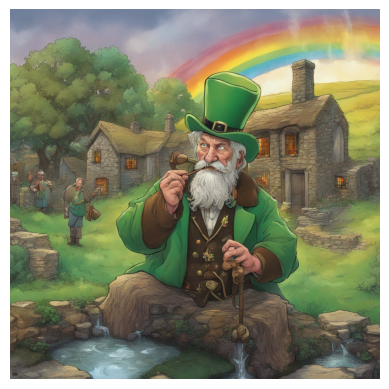

In [41]:
#@title The Leprachaun
prompt="""
Comic book cover: {A vivid scene at the old Wishing Well. close up on face of Leprachaun smoking a pipe with glazed eyes. The background is filled with lush Irish landscapes and a sparkling rainbow.}, digital photograph, lush Irish countryside, Camera: 70mm, Shot: medium shot, Render Related Information: 4K, highly detailed, natural light, Octane render.
"""
image = diffusion.run_inference(prompt, 7.0)
diffusion.display_image(image)

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: [', shot : close - up, render related information : 6 4 k, ( bright colors : 1. 3 )']
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: [', shot : close - up, render related information : 6 4 k, ( bright colors : 1. 3 )']


  0%|          | 0/32 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: [', shot : close - up, render related information : 6 4 k, ( bright colors : 1. 3 )']


  0%|          | 0/8 [00:00<?, ?it/s]

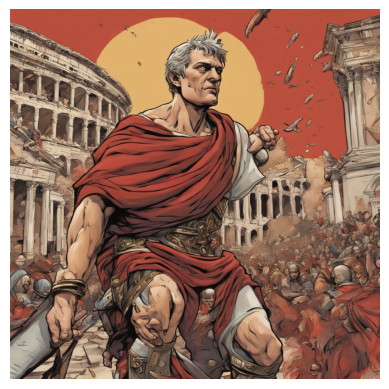

In [42]:
#@title Hail Caeser!
prompt="""
Comic book cover, {An action-packed scene from Rome, showcasing Caesar's grandeur and the vibrancy of Roman life. Caesar is depicted close up in a heroic pose, bestowing favor. The background is filled with Roman architecture, soldiers, and citizens, all in celebration.}, abstract expressionism, Inspired by Deviantart and Dribble, Camera: fish-eye, Shot: close-up, Render Related Information: 64K, (bright colors:1.3)
"""
image = diffusion.run_inference(prompt, 8.0)
diffusion.display_image(image)

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['.']
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['.']


  0%|          | 0/32 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['.']


  0%|          | 0/8 [00:00<?, ?it/s]

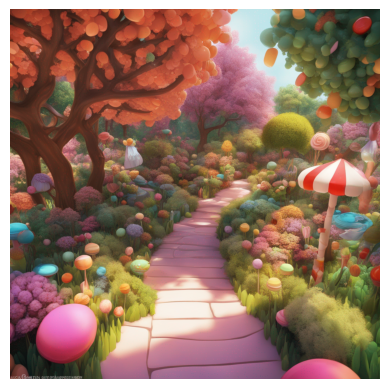

In [43]:
#@title Candy Land
prompt="""
cartoon illustration, {Idylic garden scene where all the trees, bushes, flowers and plants are made from candy}, surrealism, Inspired by Art Station and Behance, Camera: fish-eye, Shot: close-up, Render Related Information: 8K, (bright colors:1.3), (highly detailed:1.25), soft light, Unreal Engine."""
image = diffusion.run_inference(prompt, 8.0)
diffusion.display_image(image)

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['colors : 1. 2 5 ), natural light, unity engine.']
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['colors : 1. 2 5 ), natural light, unity engine.']


  0%|          | 0/32 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['colors : 1. 2 5 ), natural light, unity engine.']


  0%|          | 0/8 [00:00<?, ?it/s]

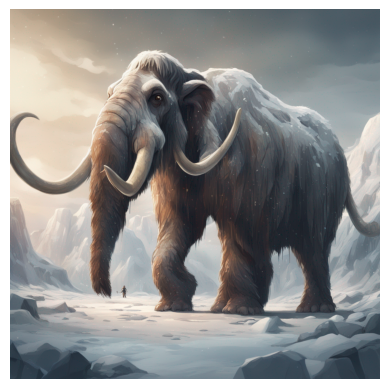

In [8]:
prompt = "cartoon illustration, {A dynamic Ice Age scene featuring a giant mammoth, set against a backdrop of icy landscapes. The atmosphere is thrilling and conveys the grandeur of the era}, abstract expressionism, Inspired by Deviantart and Behance, Camera: wide angle, Shot: panoramic, Render Related Information: 4K, (hyper detailed:1.16), (vivid colors:1.25), natural light, Unity Engine."

image = diffusion.run_inference(prompt, 7.0)
diffusion.display_image(image)

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

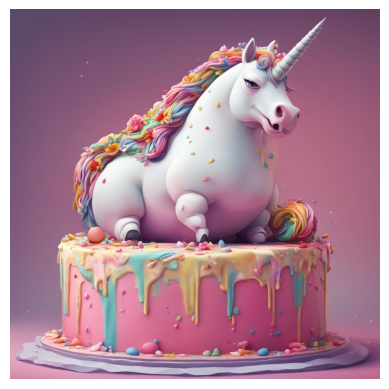

In [9]:
prompt = "cartoon illustration, {overweight unicorn looking embarrased sitting on a giant cake}, abstract expressionism, Inspired by Deviantart and Behance, Camera: wide angle, Shot: panoramic, Render Related Information: 4K, (hyper detailed:1.16), (vivid colors:1.25), natural light, Unity Engine."

image = diffusion.run_inference(prompt, 7.0)
diffusion.display_image(image)

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['engine.']
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['engine.']


  0%|          | 0/32 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['engine.']


  0%|          | 0/8 [00:00<?, ?it/s]

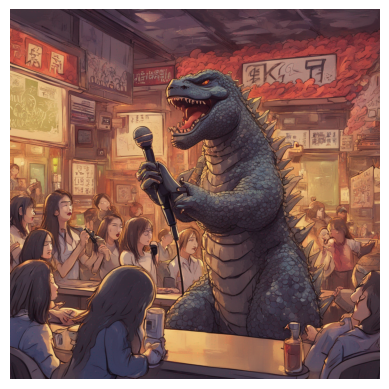

In [44]:
prompt = "cartoon illustration, {godzilla singing a song at a karaoke bar holding a microphone, japanese women in the background. tokyo setting}, abstract expressionism, Inspired by Deviantart and Behance, Camera: wide angle, Shot: panoramic, Render Related Information: 4K, (hyper detailed:1.16), (vivid colors:1.25), natural light, Unity Engine."

image = diffusion.run_inference(prompt, 9.0)
diffusion.display_image(image)

In [12]:
#https://colab.research.google.com/github/R3gm/InsightSolver-Colab/blob/main/SDXL_1_0_with_T2I_Adapter_ControlNet_Inpainting_Train_Lora.ipynb#scrollTo=A9NXfCSEQtWo